# Analysis part - Blastoise___Holo_1999_Base_Set

In [3]:
library(ggplot2)
library(quantreg)


df = read.csv('lagged_merged_datasets_final/merged_Blastoise___Holo_1999_Base_Set.csv')

#convert prices to returns
grades <- grep("grade[0-9]+price", names(df), value = TRUE)
grade_returns <- sapply(grades, function(x) paste0(x, "_return"))

for(grade in grades) {
  df[paste(grade, "return", sep = "_")] <- c(NA, diff(log(df[[grade]])))
}

#convert adjclosestock and adjclosebond (including their lags) to returns
stock_bond_cols <- grep("adjclose(stock|bond)(lag[0-9]+)?", names(df), value = TRUE)

for(col in stock_bond_cols) {
  df[paste0(col, "_return")] <- c(NA, diff(log(df[[col]])))
}


#convert volume and its lags to 'returns'
volume_cols <- grep("volume(lag[0-9]+)?", names(df), value = TRUE)

for(col in volume_cols) {
  df[paste0(col, "_return")] <- c(NA, diff(log(df[[col]])))  # Adding 1 to avoid log(0) issues
}

#remove rows with NA in the newly created return columns
df <- na.omit(df)

print(head(df))




        date grade5price grade6price grade7price grade8price grade9price
2 2016-10-01          10       18.25        25.0    48.95125     76.0000
3 2016-11-01          10       18.25        25.0    29.51750     76.0000
4 2016-12-01          10       24.99        25.0    26.72000     39.6200
5 2017-01-01          10       24.99        20.5    31.00000     78.4175
6 2017-02-01          10       24.99        20.5    23.25000     55.9920
7 2017-03-01          10       24.99        20.5    24.50000     76.5120
  grade10price adjclosestock      volume adjclosebond  stockreturns
2        222.5       2126.15 72915530000        2.589 -0.0194256789
3        222.5       2198.81 88445380000        3.017  0.0341745218
4        222.5       2238.83 75344550000        3.063  0.0182007624
5        192.5       2278.87 70576420000        3.051  0.0178843582
6        151.0       2363.64 69260940000        2.968  0.0371981601
7        151.0       2362.72 81664010000        3.018 -0.0003891971
  bondadjuste

                         grade5price_return grade6price_return
grade5price_return              1.000000000        0.323184576
grade6price_return              0.323184576        1.000000000
grade7price_return              0.359460227        0.332780500
grade8price_return              0.139434340        0.073062694
grade9price_return              0.324402608       -0.014209261
grade10price_return             0.323062331        0.176325554
adjclosestock_return           -0.103897384       -0.041649136
adjclosebond_return             0.134898223        0.043957486
adjclosestocklag1_return       -0.064438272        0.150667913
adjclosebondlag1_return        -0.008550571        0.028571345
adjclosestocklag2_return        0.120982630        0.106178462
adjclosebondlag2_return         0.024484364        0.146357139
adjclosestocklag3_return        0.088561160        0.086422365
adjclosebondlag3_return        -0.345088175       -0.234190366
adjclosestocklag4_return       -0.184383117       -0.26

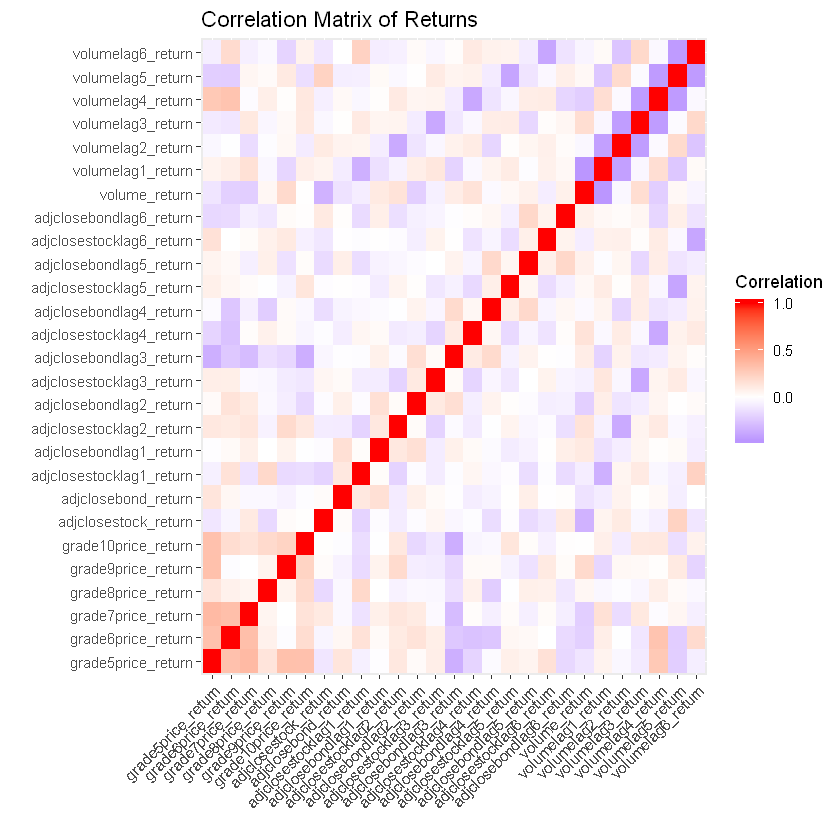

In [5]:
createReturnsCorrelationMatrix <- function(df) {
  # Load necessary libraries
  library(ggplot2)
  library(reshape2)
  
  # Use a simplified pattern to include both "_return" columns and any "volume" columns
  pattern <- "_return"
  selected_columns <- grep(pattern, names(df), value = TRUE)
  
  # Calculate the correlation matrix for the selected columns
  correlation_matrix <- cor(df[, selected_columns], use = "complete.obs")
  
  # Print the correlation matrix to the console
  print(correlation_matrix)
  
  # Melt the correlation matrix for visualization
  melted_correlation_matrix <- melt(correlation_matrix)
  
  # Create the ggplot object for the correlation matrix
  plot <- ggplot(data = melted_correlation_matrix, aes(x=Var1, y=Var2, fill=value)) +
    geom_tile() +
    scale_fill_gradient2(midpoint=0, low="blue", high="red", mid="white") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(x='', y='', title='Correlation Matrix of Returns', fill='Correlation')
  
  # Explicitly print the ggplot object to ensure it's displayed
  print(plot)
  
  # Return the correlation matrix as well
  return(correlation_matrix)
}

# Assuming your adjusted dataset is in 'df'
# Example usage:
correlation_matrix <- createReturnsCorrelationMatrix(df)


## VAR model - try later - if enough time...

## Visualisation

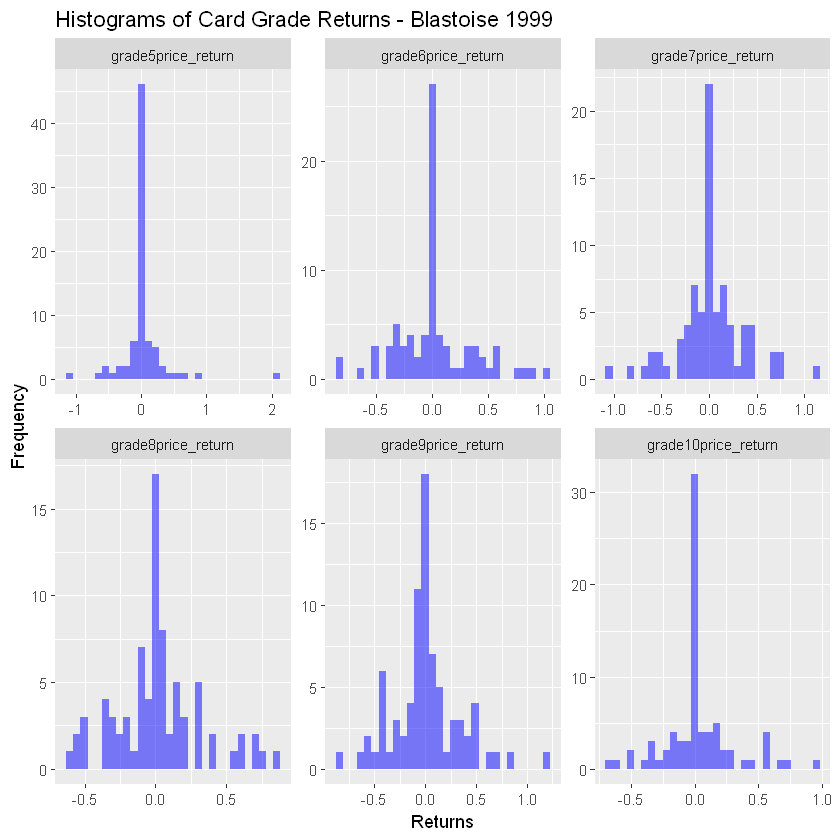

In [7]:

#create a long format data frame suitable for faceting with returns
long_df <- reshape2::melt(df, id.vars = "date", measure.vars = grade_returns)

#histograms for card grade returns
p1 <- ggplot(long_df, aes(x = value)) +
  geom_histogram(bins = 30, fill = "blue", alpha = 0.5) +
  facet_wrap(~ variable, scales = "free") +
  labs(x = "Returns", y = "Frequency", title = "Histograms of Card Grade Returns - Blastoise 1999")

print(p1)

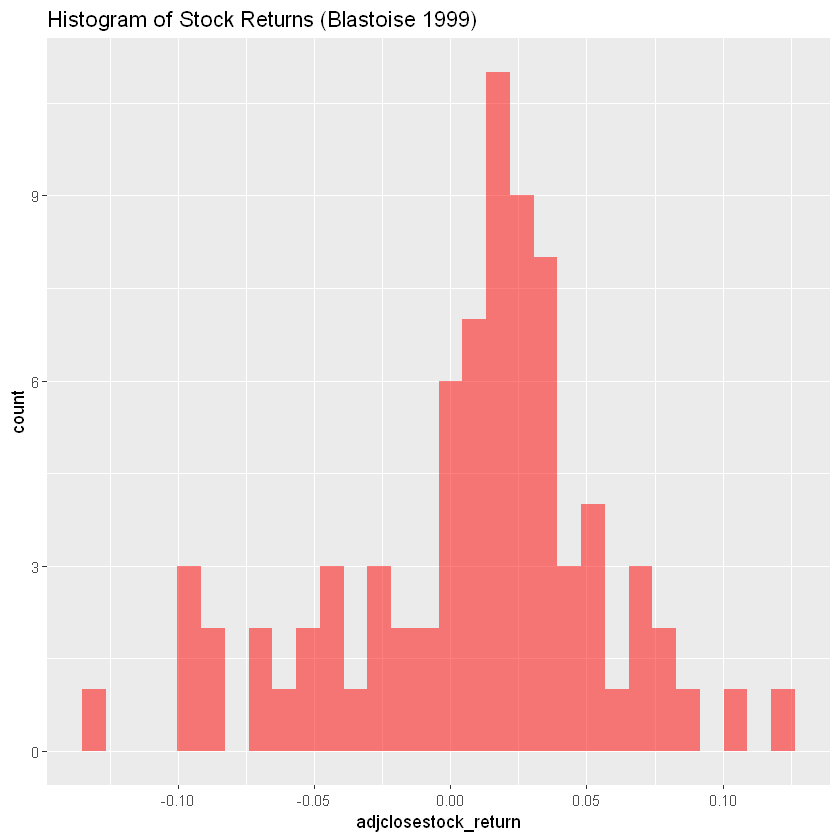

In [8]:
#histogram of stock returns
p2 <- ggplot(df, aes(x = adjclosestock_return)) +
  geom_histogram(bins = 30, fill = "red", alpha = 0.5) +
  labs(title = "Histogram of Stock Returns (Blastoise 1999)")

print(p2)

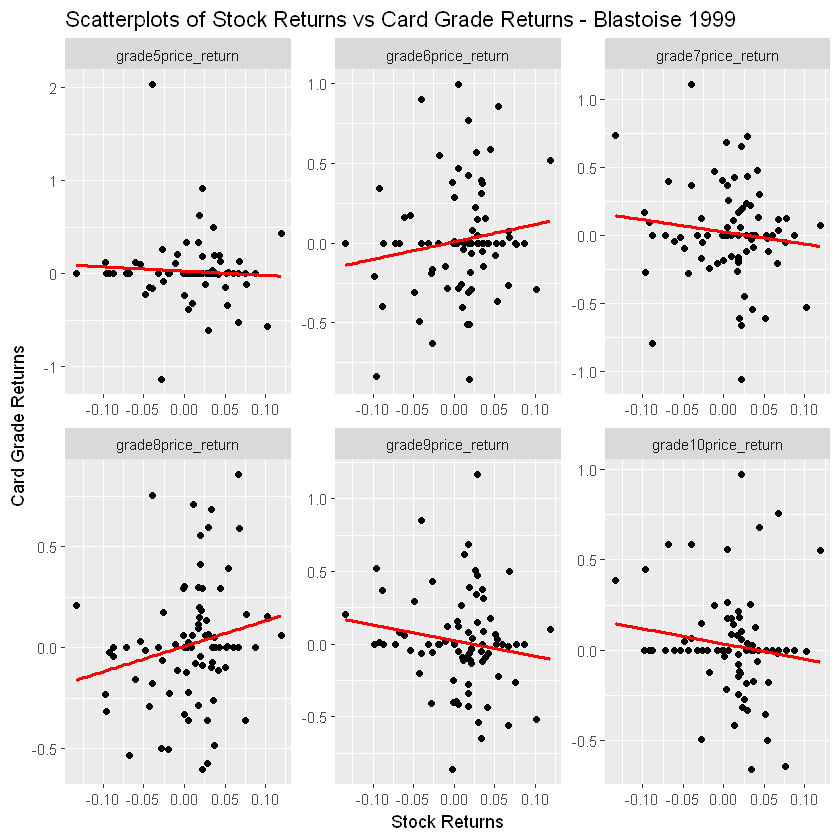

In [19]:
#a long format data frame suitable for scatterplots with returns
long_df <- reshape2::melt(df, id.vars = c("date", "adjclosestocklag1_return"), measure.vars = grade_returns) #ADJUST FOR DIFFERENT LAGS

#scatterplots between stock returns and card grades returns
p3 <- ggplot(long_df, aes(x = adjclosestocklag1_return, y = value)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE, color = "red") +
  facet_wrap(~ variable, scales = "free") +
  labs(x = "Stock Returns", y = "Card Grade Returns", title = "Scatterplots of Stock Returns vs Card Grade Returns - Blastoise 1999")

print(p3)

## Choose the variables using AIC

In [11]:

# Load necessary library
library(stats)

# Preparing the initial full model with the dependent variable (choosing one of the grade prices as an example)
# and all potential independent variables (using returns and lagged returns)
# Note: Adjust 'grade5price' to the specific grade price return you are analyzing
full_model <- lm(grade10price_return ~ adjclosestock_return + adjclosebond_return +
                 adjclosestocklag1_return + adjclosebondlag1_return +
                 adjclosestocklag2_return + adjclosebondlag2_return +
                 adjclosestocklag3_return + adjclosebondlag3_return +
                 adjclosestocklag4_return + adjclosebondlag4_return +
                 adjclosestocklag5_return + adjclosebondlag5_return +
                 adjclosestocklag6_return + adjclosebondlag6_return +
                 volume_return + volumelag1_return + volumelag2_return + volumelag3_return + 
                 volumelag4_return + volumelag5_return + volumelag6_return, data = df)

# Perform backward elimination based on AIC
reduced_model <- step(full_model, direction = "backward")

# Display the summary of the reduced model to see the selected variables and their coefficients
summary(reduced_model)


Start:  AIC=-177.21
grade10price_return ~ adjclosestock_return + adjclosebond_return + 
    adjclosestocklag1_return + adjclosebondlag1_return + adjclosestocklag2_return + 
    adjclosebondlag2_return + adjclosestocklag3_return + adjclosebondlag3_return + 
    adjclosestocklag4_return + adjclosebondlag4_return + adjclosestocklag5_return + 
    adjclosebondlag5_return + adjclosestocklag6_return + adjclosebondlag6_return + 
    volume_return + volumelag1_return + volumelag2_return + volumelag3_return + 
    volumelag4_return + volumelag5_return + volumelag6_return

                           Df Sum of Sq    RSS     AIC
- adjclosebond_return       1   0.00005 4.8033 -179.21
- volumelag2_return         1   0.00017 4.8034 -179.21
- adjclosebondlag4_return   1   0.00083 4.8041 -179.20
- adjclosestocklag3_return  1   0.00124 4.8045 -179.19
- volumelag5_return         1   0.00185 4.8051 -179.18
- adjclosebondlag5_return   1   0.00199 4.8052 -179.18
- adjclosebondlag6_return   1   0.00426 4.807


Call:
lm(formula = grade10price_return ~ adjclosebondlag3_return, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.78283 -0.10299 -0.00871  0.10916  0.87823 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)   
(Intercept)              0.03504    0.02997   1.169  0.24591   
adjclosebondlag3_return -1.10641    0.34175  -3.237  0.00178 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2658 on 77 degrees of freedom
Multiple R-squared:  0.1198,	Adjusted R-squared:  0.1084 
F-statistic: 10.48 on 1 and 77 DF,  p-value: 0.00178


## Models

### OLS

In [16]:
#OLS
ols_model <- lm(grade10price_return ~ adjclosestocklag1_return + 
    adjclosebondlag3_return , data = df) 

print(summary(ols_model))

library(car)

# Calculate VIF
vif_result <- vif(ols_model)
print(vif_result)

library(lmtest)

# Perform the Breusch-Pagan test
bp_test <- bptest(ols_model)

# Print the test results
print(bp_test)



Call:
lm(formula = grade10price_return ~ adjclosestocklag1_return + 
    adjclosebondlag3_return, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.76062 -0.11222 -0.02125  0.10326  0.88984 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)   
(Intercept)               0.04207    0.03021   1.393  0.16780   
adjclosestocklag1_return -0.86500    0.61980  -1.396  0.16690   
adjclosebondlag3_return  -1.11334    0.33970  -3.277  0.00158 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2641 on 76 degrees of freedom
Multiple R-squared:  0.1418,	Adjusted R-squared:  0.1192 
F-statistic: 6.279 on 2 and 76 DF,  p-value: 0.002994

adjclosestocklag1_return  adjclosebondlag3_return 
                1.000214                 1.000214 

	studentized Breusch-Pagan test

data:  ols_model
BP = 7.9203, df = 2, p-value = 0.01906



According to B-P test seems like heteroskedasticity - Generalised least squares...

### Quantile regression

In [17]:
#Quantile regression
library(quantreg)

quantile_model <- rq(grade10price_return ~ adjclosestocklag1_return + adjclosebondlag3_return, data = df, tau = seq(from=0.05, to=0.95, by=0.05))  #change tau for different quantiles
                                                                                                                                   

#print summary of quantile regression models
for(grade_return in grade_returns) {
  #print(paste("Summary of quantile regression model for:", grade_return))
  #print(summary(quantile_models[[grade_return]]))
}

#uncomment the last two commented rows (in the previous loop) if you want to see the results for quantiles from 0.05 to 0.95, by 0.05 step




#### Results for different quantiles of the grade 10 prices x OLS estimates (red line) 

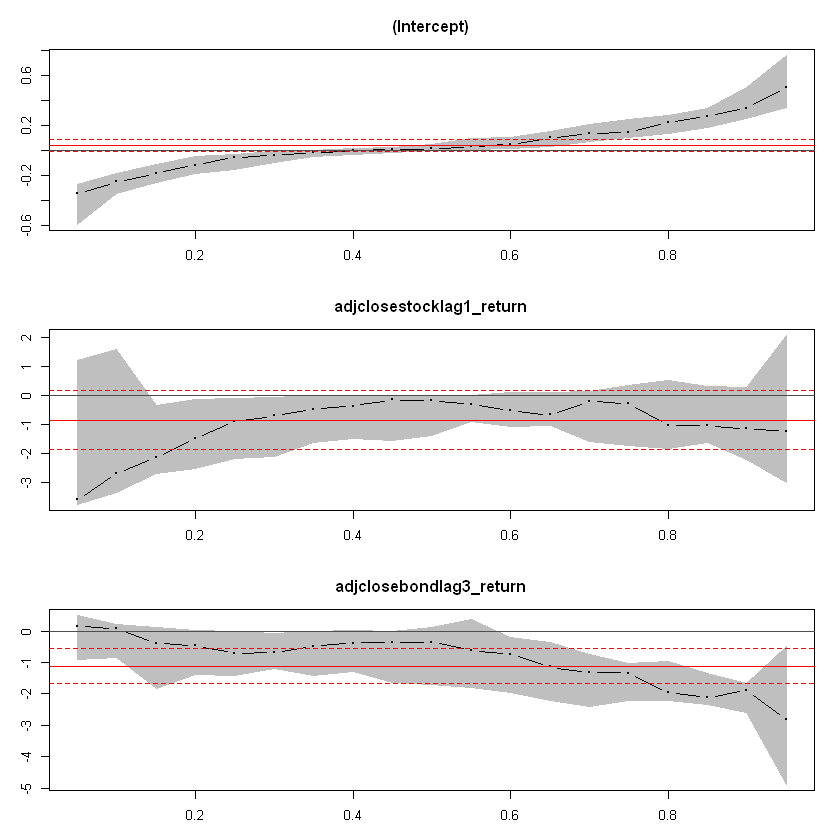

In [18]:

plot(summary(quantile_model))
